<a href="https://colab.research.google.com/github/MaggiePN92/fastai/blob/master/chap5_gc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 18.7MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 12.8MB 199kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_96.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_21.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_173.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_106.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_88.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_177.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_25.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_190.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_90.jpg')...]

In [5]:
fname = (path/"images").ls()[0]

In [6]:
fname.name

'german_shorthaired_96.jpg'

In [7]:
#find all names with "_someNumber.jpg"
re.findall(r'(.+)_\d+.jpg$', fname.name)

['german_shorthaired']

In [8]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), "name"),
                 item_tfms=Resize(460), #data augmentation
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)) #data augmentation
dls = pets.dataloaders(path/"images")

In [9]:
## Presizing
#Img have to be same dim
#Minimize distinct augmentations; loose less info & reduce computation

#Augmentation can lead to:
#- Spurious empty zones
#- Degrade data

#Rotation and resizing can require interpolation, lower quality

#Presizing adpots two strats to avoid these challenges
#1: resize to large dims, allows for further augmentation.
#resize to square, crop covers whole width or height (whichever is smaller)
#item_tfms; applied to each img before its copied to GPU
#crop is randomly choosen for training, always center for valid set
#2: compose all augmentations to one, perform the combined operation once on GPU
#random crop and augmentation, done with batch_tfms
#implement with Reize, using large size & RandomizedCrop with smaller size. Include
#min_scaler in aug_transforms function. Alt. use pad or squish instead of crop. 



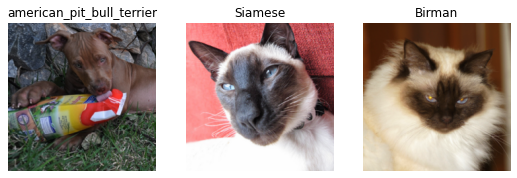

In [10]:
#debugging data
dls.show_batch(nrows=1, ncols=3)

In [11]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_119.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=356x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_119.jpg
    applying partial gives
      Bengal
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=356x500, TensorCategory(1))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: 

In [12]:
#time to train simple baseline model, check if:
#-easy problem
#-data doesn't train model

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.520774,0.327026,0.104871,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.506164,0.295899,0.096752,01:07
1,0.315069,0.206414,0.062923,01:09


In [13]:
#fastai finds sutiable loss fn., here it uses cross-entropy loss; faster and 
#more reliable training 

In [14]:
x,y = dls.one_batch()
#37 different breeds
y

TensorCategory([25,  8, 22,  4,  0, 35, 24, 36, 25, 22, 22, 10, 18, 21, 30, 34, 10, 11,
         5, 28, 14, 13, 22, 25, 17,  5, 16, 35,  8, 21, 23, 20,  1,  7, 14, 13,
        26, 25, 14, 21, 14, 27,  2, 30, 24, 15,  6,  1,  7,  6,  6, 18, 30, 28,
        17, 20, 10, 21, 32, 26,  6,  3, 11, 29], device='cuda:0')

In [15]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.2076e-07, 2.8199e-07, 1.8094e-06, 1.2243e-07, 2.5176e-09, 1.1788e-07,
        1.7133e-06, 9.6083e-09, 4.6945e-08, 6.3883e-07, 3.2406e-07, 1.2762e-07,
        3.8937e-08, 4.1570e-07, 8.7740e-07, 6.0663e-08, 7.1837e-06, 3.0630e-07,
        1.7993e-06, 2.3346e-07, 3.9276e-06, 7.9890e-06, 5.2274e-07, 7.6544e-07,
        4.4728e-05, 9.9981e-01, 4.5110e-07, 4.9434e-05, 2.3392e-07, 3.6976e-07,
        6.2075e-05, 1.4388e-06, 7.8487e-07, 1.5761e-07, 3.4112e-08, 3.8023e-06,
        1.1297e-07])

In [16]:
len(preds[0]), preds[0].sum()

(37, tensor(1.0000))

In [17]:
#first col is prob for 3 and second is 7
acts = torch.randn((6,2))*2
acts

tensor([[-2.7469,  1.2929],
        [-3.3264, -0.6674],
        [-1.2777,  1.2582],
        [ 1.1777,  2.5570],
        [-1.6045, -3.3076],
        [ 2.2148, -2.0914]])

In [18]:
acts.sigmoid()

tensor([[0.0603, 0.7846],
        [0.0347, 0.3391],
        [0.2179, 0.7787],
        [0.7645, 0.9280],
        [0.1674, 0.0353],
        [0.9016, 0.1099]])

In [19]:
#sigmoid(-2.7469 - 1.2929)
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.0173, 0.0654, 0.0734, 0.2011, 0.8459, 0.9867])

In [20]:
#multi-cat equivalent of sigmoid
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [21]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

In [22]:
targ = tensor([0,1,0,1,1,0])
sm_acts

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

In [23]:
#[row, col]
idx = range(6)
#wish to max each prob
sm_acts[idx, targ]
#NLL, wants to min this:
-sm_acts[idx, targ]
#pytorch eq:
F.nll_loss(sm_acts, targ, reduction="none")

tensor([-0.0173, -0.9346, -0.0734, -0.7989, -0.1541, -0.9867])

In [24]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x));
    if tx is not None: ax.set_xlabel(tx);
    if ty is not None: ax.set_ylabel(ty);
    if title is not None: ax.set_title(title);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  


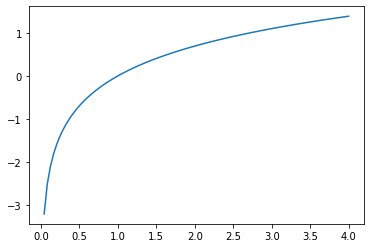

In [25]:
#Taking the log; from probs (0,1) to (-inf,inf) w/logs
plot_function(torch.log, min=0, max=4)

In [26]:
#cross-entropy loss:
#softmax -> log likelihood
nn.CrossEntropyLoss(reduction="none")(acts, targ)

tensor([4.0573, 0.0677, 2.6122, 0.2245, 1.8704, 0.0134])

In [27]:
acts

tensor([[-2.7469,  1.2929],
        [-3.3264, -0.6674],
        [-1.2777,  1.2582],
        [ 1.1777,  2.5570],
        [-1.6045, -3.3076],
        [ 2.2148, -2.0914]])

In [28]:
sm_acts#[idx, targ]

tensor([[0.0173, 0.9827],
        [0.0654, 0.9346],
        [0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133]])

In [29]:
sm_acts[idx, targ]

tensor([0.0173, 0.9346, 0.0734, 0.7989, 0.1541, 0.9867])

In [30]:
sm_acts[idx, targ].log()

tensor([-4.0573, -0.0677, -2.6122, -0.2245, -1.8704, -0.0134])

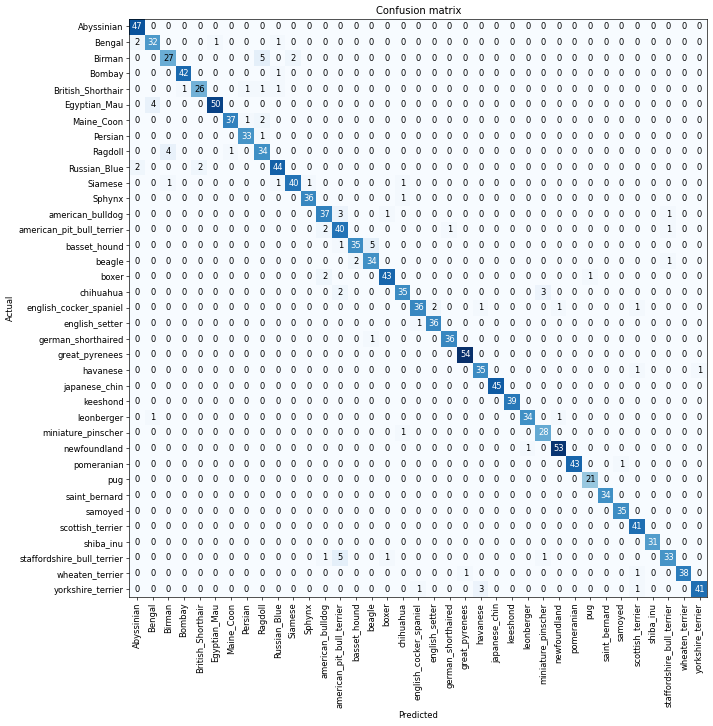

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
interp.most_confused(min_val=5)

[('Birman', 'Ragdoll', 5),
 ('basset_hound', 'beagle', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

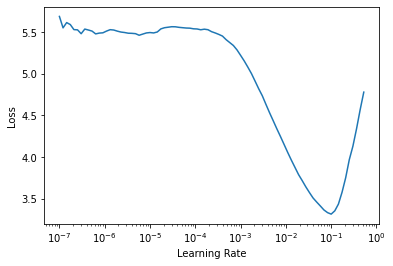

In [33]:
#the learning rate finder
learn = cnn_learner(dls, resnet34, metrics=error_rate)
#plotted in log-scale
lr_min, lr_steep = learn.lr_find()

In [34]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.02e-03


In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.273767,0.322506,0.105548,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.549283,0.364432,0.117727,01:08
1,0.325250,0.243366,0.073748,01:08


In [36]:
##UNFREEZING AND TRANSFER LEARNING
'''
Freezing: just optimize weights of last layer
FastAI automatically freezes layers when calling a pretrained model
When calling fine_tune, fastai does two things:
- Trains the randomly added layers for one epoch
- Unfreezes pretrained layers, and trains them for the remaining epochs
'''

'\nFreezing: just optimize weights of last layer\nFastAI automatically freezes layers when calling a pretrained model\nWhen calling fine_tune, fastai does two things:\n- Trains the randomly added layers for one epoch\n- Unfreezes pretrained layers, and trains them for the remaining epochs\n'

In [37]:
learn.fit_one_cycle??

In [38]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
#fit one cycle gradually increases lr and then gradually decreases it
learn.fit_one_cycle(n_epoch=3, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.157932,0.345323,0.110961,01:05
1,0.523876,0.232551,0.076455,01:04
2,0.320381,0.220080,0.068336,01:04


In [39]:
learn.unfreeze()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=1.5848931980144698e-06)

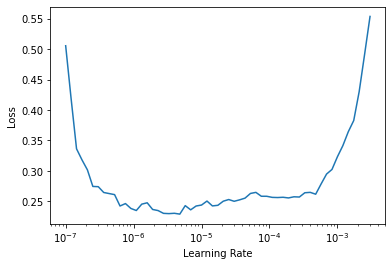

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.262196,0.212291,0.067659,01:07
1,0.251575,0.208440,0.071042,01:07
2,0.221406,0.197126,0.065629,01:07
3,0.201417,0.196295,0.062923,01:07
4,0.195618,0.193542,0.061570,01:07
5,0.186991,0.193289,0.057510,01:07


In [41]:
##Discriminative learning rates
#Use lower learning rate early in network when using pretrained models

In [42]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
#first val is lr of first layers, last vals lr of last layers
#lr gradually increases from 1e-6 ro 1e-4
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.136111,0.347627,0.107578,01:03
1,0.530368,0.223608,0.081867,01:03
2,0.329098,0.201884,0.071719,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.280405,0.191804,0.067659,01:06
1,0.266331,0.182913,0.054804,01:07
2,0.240222,0.182143,0.060217,01:07
3,0.219072,0.167862,0.060217,01:07
4,0.204757,0.177266,0.058187,01:07
5,0.162685,0.174248,0.056157,01:07
6,0.157832,0.175872,0.060217,01:07
7,0.153875,0.170360,0.055480,01:07
8,0.134148,0.166479,0.056834,01:06
9,0.134701,0.166320,0.052774,01:07


In [43]:
##Selecting # of epochs
#Don't care about loss; care about metric, val loss getting worse is 
#due to model being overconfident in it's predictions, and eventually 
#due to incorrecly memorizing data

#Early stopping is old fashioned; will stop before lr has reached small vals
#this is where best results are achieved. 
#If you have overfit: retrain model from scratch, select # epochs based
#on previously best result. If you have time for many epochs; perhaps train
#deeper network. 

In [44]:
##Deeper architectures
from fastai.callback.fp16 import *
#using half precision floating points; this speeds up training
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.266432,0.288029,0.100135,01:07
1,0.564663,0.254405,0.080514,01:06
2,0.430571,0.251988,0.079161,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.281910,0.269454,0.084574,01:09
1,0.333341,0.313797,0.093369,01:08
2,0.229941,0.244434,0.070365,01:09
3,0.159489,0.198962,0.060217,01:09
4,0.085529,0.159387,0.050744,01:09
5,0.072724,0.168296,0.050744,01:09
